# CDS - Casual Inference with Deep Survival Model and Time-varying Covariates


This tutorial demonstrates the basic function of the causal dynamic survival model (CDS).

In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.random.set_seed(1234)
from utilss.model import create_model, get_counterfactuals, fit_model
from utilss.data_simulator import get_data
from lifelines import KaplanMeierFitter

In [16]:
def print_km(df):
    kmf = KaplanMeierFitter(label="AF")
    kmf.fit(df[df['A'] == 1]['T'], df[df['A'] == 1]['Y'])
    kmf1 = KaplanMeierFitter(label="AF2")
    kmf1.fit(df[df['A'] == 0]['T'], df[df['A'] == 0]['Y'])
    return kmf, kmf1

## Data simulation

To explore the finite-sample performance of CDS, we ran several experiments with biologically plausible longitudinal
data following the main paper. Here, we demonstrate one experiment with the following settings:
<br>
- $6 \text{ continuous covariates }X(0)_1,X(0)_2,\dots,X(0)_D\sim\mathrm{N}(0,0.5)$
- A binary exposure generated at time 0 with the indicator function $A=I(\sum_{i=1}^DX(0)_i\geq\frac{\eta}{D}\sum_{i=1}^DX(0)_i )$,
where $\eta$ controls the balance of treated and control observations in the sample, with $100(1.5-\eta)\%$ of the sample receiving the treatment; and
- Individual survival curves generated using the hazard function $h_i(t) = \frac{\log(t)}{\lambda}\big(\beta_0 A_i+\beta_1\sum_{i=1}^6 X(t)_i\big)$
- The event/censor time are generated using the root finding technique according to our original work.


In [19]:
print("simulating..." )
max_time = 10
simu_dim = 6
history_itvl = 5
sampleSize = 3000
confound = 0.25
scale = 2
std = 0.2

surv_func_wrapper, surv_func_wrapper_test, train, val, test = \
    get_data(input_dim=simu_dim,
             sampleSize=sampleSize,
             max_time=max_time,
             history_itvl=history_itvl,
             seed=1234,
             std=std,
             confound=confound, scale=scale, dynamic=True)
print("simulation completed!" )


def get_true(df, A=None):
    y1_true_grid = np.zeros((len(np.unique(df.ID)), max_time))
    h1_grid = np.zeros((len(np.unique(df.ID)), max_time))
    p_series = []
    for i in np.unique(df['T1']):
        pt = np.array(np.sum(df[df['T1'] == i][['' + str(i) for i in np.arange(1, simu_dim + 1)]], 1))
        p_series.append(pt.reshape(len(pt), 1))
    p_series = np.concatenate(p_series, 1)
    p_series = np.mean(p_series, 1)

    if isinstance(A, int):
        Ak = A
    else:
        Ak = df.groupby(['ID']).apply(lambda x: np.mean(x['A']))

    for k in range(0, max_time):
        t_effect = (k) ** (1 / scale)
        y1_true_grid[:, k] = (p_series * t_effect + Ak) / 10
        h1_grid[:, k] = k * 0.001 + y1_true_grid[:, k]

    true_potential_outcomes = np.array([np.exp(- h) for h in h1_grid])
    true_potential_outcomes[:, 0] = 1
    true_potential_outcomes = np.cumprod(true_potential_outcomes, 1)
    return true_potential_outcomes

trueSurv_wrapper_1 = get_true(test, 1)
trueSurv_wrapper_0 = get_true(test, 0)

simulating...
generating sample...........done!
simulation completed!


## Model training

In [20]:
model = create_model(simu_dim, history_itvl, max_time)
best_models = fit_model(model, max_time, simu_dim=simu_dim, history_itvl=history_itvl,
                        train=train.astype('float32'), val=val.astype('float32'))
result = get_counterfactuals(best_models, test, simu_dim=simu_dim, max_time=max_time,
                                                       history_itvl=history_itvl)

print("training completed!" )

search hype...INFO:tensorflow:Oracle triggered exit
.

100%|██████████| 1500/1500 [00:00<00:00, 18062.08it/s]


INFO:tensorflow:Oracle triggered exit
...............done!


100%|██████████| 2000/2000 [00:00<00:00, 14014.04it/s]


predicting...[-0.00156939 -0.0567773  -0.06216776 -0.08296722 -0.05899739 -0.07405949
 -0.07875896 -0.0514183  -0.06242132  0.00118339]
done!
training completed!


In [21]:
surv_ind_0, surv_ind_1, surv_ind_std_0, surv_ind_std_1, ite, ite_std, ate, ate_std, hr, hr_std = result



## Result


ATE curves: Blue is the estimated ATE curve, grey is the KM estimation and green is the true curve.

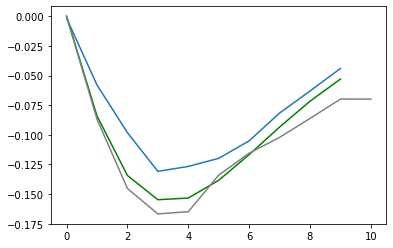

In [22]:
kmf, kmf1 = print_km(test)
plt.plot(ate)
plt.plot(np.mean(trueSurv_wrapper_1 - trueSurv_wrapper_0, 0), color='green')
plt.plot(np.array(kmf.survival_function_)[0:25] - np.array(kmf1.survival_function_)[0:25], color='grey')
plt.show()

ITE curves: Blue is the estimated ATE curve and green is the true curve.

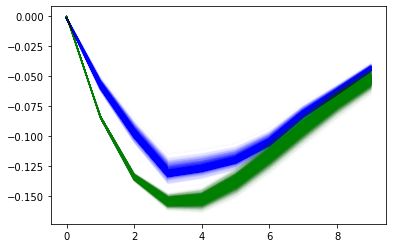

In [27]:
kmf, kmf1 = print_km(test)
plt.plot(ite.T, alpha = 0.01, color='blue')
plt.plot((trueSurv_wrapper_1 - trueSurv_wrapper_0).T, color='green', alpha = 0.01)
plt.show()

Counterfactual survival curves: dashed lines are the true curves, solid lines are the estimated curves. Grey for the control and blue for the treated.

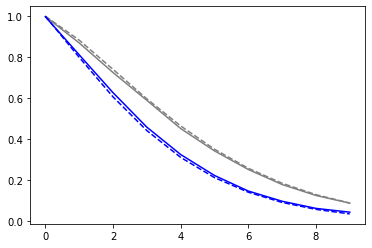

In [28]:
plt.plot(np.mean(surv_ind_0, 0), color='grey')
plt.plot(np.mean(trueSurv_wrapper_0, 0), '--', color='grey')
plt.plot(np.mean(surv_ind_1, 0), color='blue')
plt.plot(np.mean(trueSurv_wrapper_1, 0), '--', color='blue')
plt.show()